In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# 1. MNIST train, test dataset 가져오기

In [2]:
# "": 현재 폴더에 MNIST 있음
mnist_train = dset.MNIST("", train = True, transform = transforms.ToTensor(),
                         target_transform = None, download = True)
mnist_test = dset.MNIST("", train = False, transform = transforms.ToTensor(),
                        target_transform = None, download = True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw



# 2. 대략적인 데이터 형태

mnist_train 길이 :  60000
mnist_test 길이 :  10000
image data 형태 :  torch.Size([1, 28, 28])
label :  5


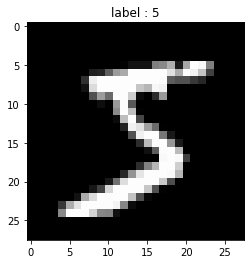

In [3]:
print("mnist_train 길이 : ", len(mnist_train))
print("mnist_test 길이 : ", len(mnist_test))

# 데이터 하나 형태
image, label = mnist_train.__getitem__(0) # 0번째 데이터
print("image data 형태 : ", image.size())
print("label : ", label)

# 그리기
img = image.numpy() # image 타입을 numpy로 변환 (1, 28, 28)
plt.title("label : %d" %label)
plt.imshow(img[0], cmap = 'gray')
plt.show()

# 3. 데이터 로드 함수
### 학습시킬 때 batch_size 단위로 끊어서 로드하기 위함

In [4]:
# hyper parameters
batch_size = 1024
learning_rate = 0.01
num_epoch = 400

In [5]:
train_loader = torch.utils.data.DataLoader(mnist_train,
                                           batch_size = batch_size, # mnist_train을 train시키자
                                           shuffle = True, num_workers = 2,
                                           drop_last = True) # batch_size 만큼 나눌 때 나머지는 버려라

test_loader = torch.utils.data.DataLoader(mnist_test, batch_size = batch_size,
                                          shuffle = False, num_workers = 2,
                                          drop_last = True)

### 데이터 로드함수 이해하기

[0]
한번에 로드되는 데이터의 크기 :  1024


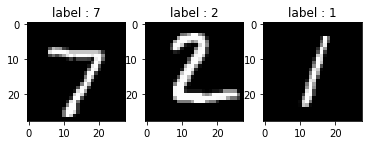

[1]
한번에 로드되는 데이터의 크기 :  1024


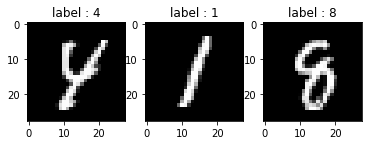

[2]
한번에 로드되는 데이터의 크기 :  1024


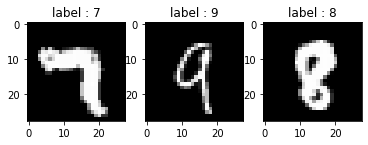

[3]
한번에 로드되는 데이터의 크기 :  1024


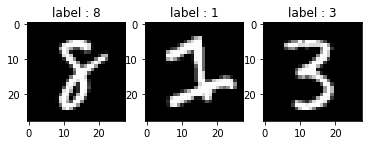

[4]
한번에 로드되는 데이터의 크기 :  1024


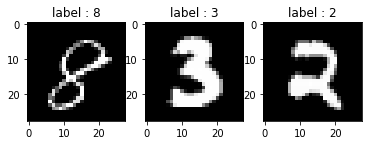

[5]
한번에 로드되는 데이터의 크기 :  1024


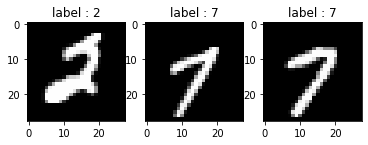

In [6]:
n = 3 # 샘플로 그려볼 데이터 개수

for i, [imgs, labels] in enumerate(test_loader): # batch_size 만큼
  if i > 5:
    break

  print("[%d]" %i)
  print("한번에 로드되는 데이터의 크기 : ", len(imgs))

  # 그리기
  for j in range(n):
    img = imgs[j].numpy() # image 타입을 numpy로 변환 (1, 28, 28)
    img = img.reshape((img.shape[1], img.shape[2])) # (1, 28, 28) -> (28, 28)
    # print(img.shape)

    plt.subplot(1, n, j + 1) # (1, 3) 형태 플롯의 j 번째 자리에 그리겠다
    plt.imshow(img, cmap = 'gray')
    plt.title("label : %d" %labels[j])

  plt.show()

# 4. 모델 선언

In [7]:
# 모델 선언
# * 퍼셉트론(2 hidden layer) *
model = nn.Sequential(
    nn.Linear(28 * 28, 256),
    nn.Sigmoid(),
    nn.Linear(256, 128),
    nn.Linear(128, 10)
)

# 파라미터 보기
print(list(model.parameters())) # 초기 파라미터 출력

[Parameter containing:
tensor([[ 0.0223, -0.0333, -0.0054,  ...,  0.0154,  0.0027, -0.0090],
        [-0.0122, -0.0202,  0.0295,  ..., -0.0092,  0.0317,  0.0136],
        [ 0.0084,  0.0154,  0.0297,  ..., -0.0031, -0.0305,  0.0211],
        ...,
        [ 0.0199, -0.0167,  0.0264,  ..., -0.0339,  0.0318,  0.0313],
        [-0.0121, -0.0014,  0.0140,  ...,  0.0165, -0.0056,  0.0256],
        [ 0.0029, -0.0238, -0.0344,  ..., -0.0141,  0.0355,  0.0197]],
       requires_grad=True), Parameter containing:
tensor([-2.9488e-02, -2.2879e-02,  2.5656e-02, -3.2144e-02,  1.1184e-02,
        -1.5162e-02,  2.7713e-02, -3.1032e-02, -1.6269e-02,  3.2677e-02,
        -1.2067e-02,  3.3871e-02, -2.1379e-02,  3.2783e-02,  1.3441e-03,
         2.4408e-02, -2.9921e-02,  2.0409e-03, -7.8817e-03, -2.7116e-02,
        -1.6563e-02, -2.7556e-03, -6.6665e-03, -1.8132e-02,  1.9928e-02,
         1.1672e-02,  2.9204e-02, -2.0765e-02, -2.3907e-02,  2.8959e-02,
        -3.0904e-02,  4.7324e-03,  4.8436e-03, -8.8573e

In [8]:
model = model.cuda()

In [9]:
def ComputeAccr(dloader, imodel):
  correct = 0
  total = 0

  for j, [imgs, labels] in enumerate(dloader): # batch_size 만큼
    img = imgs # x
    # label = Variable(labels) # y
    label = Variable(labels).cuda()
    # .cuda() : GPU에 로드하기 위함. 만약 CPU로 설정되어 있다면 에러남

    # (batch_size, 1, 28, 28) -> (batch_size, 28, 28)
    img = img.reshape((img.shape[0], img.shape[2], img.shape[3]))
    # (batch_size, 28, 28) -> (batch_size, 28 * 28)
    img = img.reshape((img.shape[0], img.shape[1] * img.shape[2]))
    # img = Variable(img, requires_grad = False)
    img = Variable(img, requires_grad = False).cuda()

    output = imodel(img) # forward prop.
    _, output_index = torch.max(output, 1)

    total += label.size(0)
    correct += (output_index == label).sum().float()

  print("Accuracy of Test Data : {}".format(100 * correct / total))

In [10]:
ComputeAccr(test_loader, model)

Accuracy of Test Data : 9.733073234558105


# 5. loss, optimizer

In [11]:
loss_func = nn.CrossEntropyLoss() # logit(# of classes), target(1)
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

# 6. 학습

In [12]:
num_epoch = 400

for i in range(num_epoch):
  for j, [imgs, labels] in enumerate(train_loader): # batch_size 만큼
    img = imgs # (batch_size, 1, 28, 28)
    # label = Variable(labels) # (batch_size)
    label = Variable(labels).cuda() # (batch_size)

    # (batch_size, 1, 28, 28) -> (batch_size, 28, 28)
    img = img.reshape((img.shape[0], img.shape[2], img.shape[3]))
    # (bathc_size, 28, 28) -> (batch_size, 28 * 28)
    img = img.reshape((img.shape[0], img.shape[1] * img.shape[2]))
    # img = Variable(img, requires_grad = True)
    img = Variable(img, requires_grad = True).cuda()

    optimizer.zero_grad()
    output = model(img) # forward prop.
    loss = loss_func(output, label) # logit(# of classes), target(1)

    loss.backward() # back prop.
    optimizer.step() # weight 조정

  if i % 50 == 0:
    print("%d.." %i)
    ComputeAccr(test_loader, model)
    print(loss)

0..
Accuracy of Test Data : 14.680989265441895
tensor(2.2966, device='cuda:0', grad_fn=<NllLossBackward0>)
50..
Accuracy of Test Data : 81.08724212646484
tensor(0.6957, device='cuda:0', grad_fn=<NllLossBackward0>)
100..
Accuracy of Test Data : 88.06423950195312
tensor(0.4276, device='cuda:0', grad_fn=<NllLossBackward0>)
150..
Accuracy of Test Data : 89.7677993774414
tensor(0.3748, device='cuda:0', grad_fn=<NllLossBackward0>)
200..
Accuracy of Test Data : 90.70095825195312
tensor(0.3013, device='cuda:0', grad_fn=<NllLossBackward0>)
250..
Accuracy of Test Data : 91.27603912353516
tensor(0.3193, device='cuda:0', grad_fn=<NllLossBackward0>)
300..
Accuracy of Test Data : 91.6015625
tensor(0.3736, device='cuda:0', grad_fn=<NllLossBackward0>)
350..
Accuracy of Test Data : 91.92708587646484
tensor(0.2749, device='cuda:0', grad_fn=<NllLossBackward0>)


# 7. 텍스트

In [13]:
ComputeAccr(test_loader, model) # 96. %(ReLU), 92.48%(ReLU X)



Accuracy of Test Data : 92.03559112548828


# 8. 학습된 파라미터 저장

In [15]:
netname = './mlp_weight.pkl'
torch.save(model, netname, )

# model = torch.load(netname)

# 9. (Optional) 실습1에 쓰인 .npz 만들려면?

In [ ]:
np.savez_compressed('./nets/mlp_weight.npz',
                    W1 = W1, b1 = b1,
                    W2 = W2, b2 = b2,
                    W3 = W3, b3 = b3)